In [1]:
from PIL import Image
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO 
import torch

model = YOLO('C:/Users/Usuario/Documents/GitHub/ANPR-GIA/yolo11n_licenseplates.pt')
test_images_dir = 'C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/images'

In [2]:
def train_yolov11(
		data_yaml,
		weights='yolo11n.pt',
		img_size=640,
		batch_size=16,
		epochs=50,
		device='0'
):
	"""
	Function to train YOLOv11 with a specified dataset.

	Parameters:
	- data_yaml: Path to the data.yaml file (specifying paths to train/val and class info)
	- weights: Path to the pretrained weights (default: yolov11s.pt)
	- img_size: Image size (default: 640)
	- batch_size: Batch size (default: 16)
	- epochs: Number of epochs for training (default: 100)
	- device: Device to run on ('0' for GPU, 'cpu' for CPU)
	"""
	print(f"Starting YOLOv11 training with {epochs} epochs on device {device}")
	model = YOLO(weights).to(device)
	model.train(
		data=data_yaml,
		imgsz=img_size,
		epochs=epochs,
		device=device
	)
	model.save('yolo11n_finetuned.pt')
	print("Training Complete.")

def run_inference(weights_path, source, img_size=640, conf_thresh=0.25, device='0'):
	"""
	Function to run inference using the trained YOLOv11 model.

	Parameters:
	- weights_path: Path to the trained weights
	- source: Directory or image path to run inference on
	- img_size: Image size for inference (default: 640)
	- conf_thresh: Confidence threshold (default: 0.25)
	- device: Device to run on ('0' for GPU, 'cpu' for CPU)
	"""
	print(f"Running inference on images in {source}")
	model = YOLO(weights_path).to(device)
	image_filenames = [filename for filename in os.listdir(source) if filename.endswith(('.jpg', '.jpeg'))]
	image_paths = [os.path.join(source, filename) for filename in image_filenames]
	results = [model(img_path, imgsz=img_size) for img_path in image_paths]
	print("Inference Complete.")
	return results

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
results_yolo = run_inference('C:/Users/Usuario/Documents/GitHub/ANPR-GIA/yolo11n_licenseplates.pt', test_images_dir, device=device)
print(results_yolo)

Running inference on images in C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/images

image 1/1 C:\Users\Usuario\Documents\GitHub\ANPR-GIA\Datasets\test\images\0550HNN_jpg.rf.79fa3912c92496ee635323f4eb29276c.jpg: 640x640 1 License Plate, 17.4ms
Speed: 0.0ms preprocess, 17.4ms inference, 145.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Usuario\Documents\GitHub\ANPR-GIA\Datasets\test\images\1062FNT_jpg.rf.e25368be438c8a1674da49f87b0195a6.jpg: 640x640 1 License Plate, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Usuario\Documents\GitHub\ANPR-GIA\Datasets\test\images\1111LRB_jpg.rf.9408c5a550f980ad9d44e3845a0bdcf4.jpg: 640x640 1 License Plate, 14.3ms
Speed: 3.0ms preprocess, 14.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\Usuario\Documents\GitHub\ANPR-GIA\Datasets\test\images\2929KXJ_jpg.rf.7b51d3ae84d4ced20ac39627603ec69b.jpg: 640x

In [4]:
box = results_yolo[0][0].boxes.xyxy[0].cpu().numpy().astype(int).tolist()
size = results_yolo[4][0].orig_img 
print((size.shape))

(640, 640, 3)


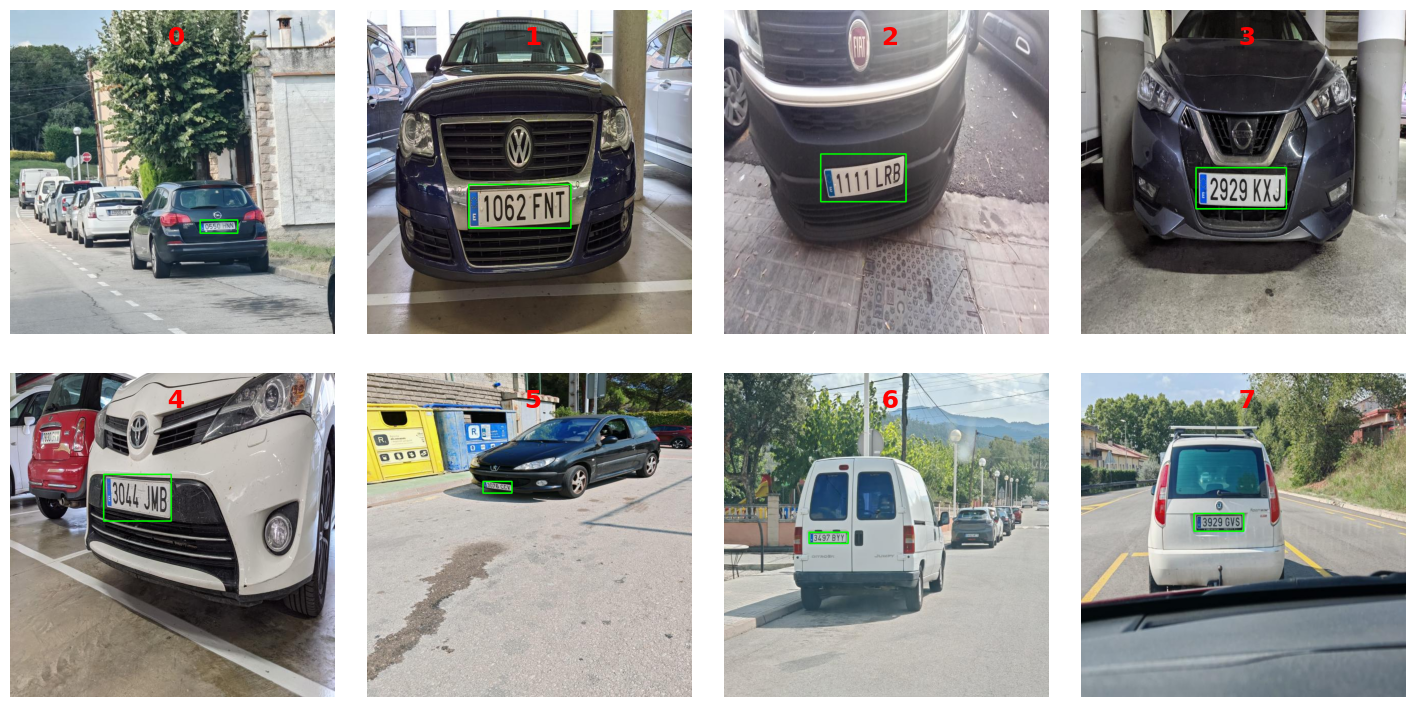

In [50]:
import cv2
import matplotlib.pyplot as plt
import math

def plot_yolo_results(results_yolo, cols=4, n_images=None, sep=1.5):
    # If n_images is not specified, display all available images
    if n_images is None:
        n_images = len(results_yolo)
    
    # Ensure we don't attempt to display more images than available
    n_images = min(n_images, len(results_yolo))
    
    # Calculate the number of rows needed based on the number of images and columns
    rows = math.ceil(n_images / cols)
    
    # Create subplots grid with specified figure size to match the previous code
    fig, axes = plt.subplots(rows, cols, figsize=(cols * sep * 3, rows * sep * 3))
    
    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    # Loop over the images and display them in subplots
    for idx in range(n_images):
        result = results_yolo[idx][0]  # Get the first result from each image's result list
        img = result.orig_img
        box = result.boxes.xyxy[0].cpu().numpy().astype(int).tolist()  # Get bounding box coordinates
        
        if img is not None:
            # Convert from BGR (OpenCV default) to RGB for proper display
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Draw the bounding box on the image
            x1, y1, x2, y2 = box
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Display the image in the corresponding subplot
            axes[idx].imshow(img)
            axes[idx].axis('off')  # Hide the axes for a cleaner look
            # Add a label (image index) above the image, centered
            axes[idx].text(0.5, 0.95, f' {idx}', color='red', fontsize=18, fontweight='bold', 
                           ha='center', va='top', transform=axes[idx].transAxes)
        else:
            print("Could not load image")  # Log a message if the image could not be loaded
    
    # Remove any unused subplots if the grid has more spaces than images
    for i in range(n_images, len(axes)):
        fig.delaxes(axes[i])
    
    # Adjust the space between images for a more aesthetic layout
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Example usage: specify number of images to display
plot_yolo_results(results_yolo, cols=4, n_images=8, sep=1.5)


In [6]:
from typing import List, Tuple, Dict
def read_ground_truth_annotations(annotation_folder: str, image_filenames: List[str]) -> dict[str, List[Tuple[int, float, float, float, float]]]:
    """
    Read  YOLO annotations

    :param annotation_folder
    :param image_filenames: 
    :return: dictionary with the result of each image
    """
    gt_annotations = {}
    for image_filename in image_filenames:
        base_name = os.path.splitext(image_filename)[0]
        annotation_file = base_name + ".txt"
        annotations = []
        path = annotation_folder+ '/' + annotation_file
        if os.path.exists(path):
            with open(path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1])
                        y_center = float(parts[2])
                        width = float(parts[3])
                        height = float(parts[4])
                        annotations.append((class_id, x_center, y_center, width, height))
        gt_annotations[image_filename] = annotations
    return gt_annotations


# Convertir de formato YOLO a coordenadas (xmin, ymin, xmax, ymax)
def yolo2corners(box):
    """
    :param: box in YOLO format (x_center, y_center, width, height )
    :return: box in format (xmin, ymin, xmax, ymax)
    """
    x_center, y_center, width, height = box
    xmin = x_center - width / 2
    ymin = y_center - height / 2
    xmax = x_center + width / 2
    ymax = y_center + height / 2
    return xmin, ymin, xmax, ymax

def calculate_iou(box1, box2):
    """
    Compute IOU

    :param box1: Tuple (x_center, y_center, width, height)
    :param box2: Tuple (x_center, y_center, width, height)
    :return: Valor de IoU
    """

    xmin1, ymin1, xmax1, ymax1 = yolo2corners(box1)
    xmin2, ymin2, xmax2, ymax2 = yolo2corners(box2)

    inter_xmin = max(xmin1, xmin2)
    inter_ymin = max(ymin1, ymin2)
    inter_xmax = min(xmax1, xmax2)
    inter_ymax = min(ymax1, ymax2)

    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Calcular las áreas de las boxes
    area1 = (xmax1 - xmin1) * (ymax1 - ymin1)
    area2 = (xmax2 - xmin2) * (ymax2 - ymin2)

    # Calcular IoU
    iou = inter_area / (area1 + area2 - inter_area) if (area1 + area2 - inter_area) != 0 else 0

    return iou

def evaluate_predictions(predictions: Dict[str, List[Tuple[int, float, float, float, float]]],
                         ground_truths: Dict[str, List[Tuple[int, float, float, float, float]]],
                         iou_threshold: float = 0.5):
    """
    Comparison with GroundTruth

    :param predictions: dictionary with the predictions of each image
    :param ground_truths: dictionary with the ground truth of each image
    :param iou_threshold: threshold that determines if it is correct or not
    :return: metrics and the lists of false positives and false negatives
    """
    total_gt = 0
    total_pred = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    false_positive_images = []
    false_negative_images = []

    for image_filename in ground_truths:
        gt_boxes = ground_truths.get(image_filename, [])
        pred_boxes = predictions.get(image_filename, [])

        matched_gt = []
        matched_pred = []

        total_gt += len(gt_boxes)
        total_pred += len(pred_boxes)

        for pred_box in pred_boxes:
            best_iou = 0
            best_gt_idx = -1
            for idx, gt_box in enumerate(gt_boxes):
                if idx in matched_gt:
                    continue
                iou = calculate_iou(pred_box[1:], gt_box[1:])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            if best_iou >= iou_threshold:
                true_positives += 1
                matched_gt.append(best_gt_idx)
                matched_pred.append(pred_box)
            else:
                false_positives += 1
                false_positive_images.append(image_filename)  # Add image to false positives

        # Identify false negatives (ground truth boxes not matched)
        for idx, gt_box in enumerate(gt_boxes):
            if idx not in matched_gt:
                false_negatives += 1
                false_negative_images.append(image_filename)  # Add image to false negatives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0

    metrics = {
        'total_ground_truth': total_gt,
        'total_predictions': total_pred,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'precision': precision,
        'recall': recall,
        'false_positive_images': false_positive_images,
        'false_negative_images': false_negative_images
    }

    return metrics



In [7]:
image_folder = 'C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/images'
annotation_folder = 'C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels'
image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]

ground_truths = read_ground_truth_annotations(annotation_folder, image_filenames)
print(ground_truths)

C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/0550HNN_jpg.rf.79fa3912c92496ee635323f4eb29276c.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/1062FNT_jpg.rf.e25368be438c8a1674da49f87b0195a6.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/1111LRB_jpg.rf.9408c5a550f980ad9d44e3845a0bdcf4.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/2929KXJ_jpg.rf.7b51d3ae84d4ced20ac39627603ec69b.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/3044JMB_jpg.rf.85bdd93a73b83e9318c53def8cb78d05.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/3076CCV_jpg.rf.f26e06a31a48a47cd53ff9715f12c5e2.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/3497BYY_jpg.rf.1a84b6203bf8cfc847b4ad41dade93cc.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/3929GVS_jpg.rf.67f0fe121d406321d9dc9d1d6e1c131f.txt
C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/labels/4283DJR_

In [8]:
def convert_yolo_results_to_gt_format(results_yolo) -> dict[str, List[Tuple[int, float, float, float, float]]]:
    """
    Convierte las predicciones YOLO en formato xyxy a formato compatible con el ground truth
    (class_id, x_center, y_center, width, height), normalizado respecto al tamaño de la imagen.
    
    :param results_yolo: Lista de resultados del modelo YOLO (Results object).
    :return: Diccionario con las predicciones en el formato {image_filename: [(class_id, x_center, y_center, width, height)]}.
    """
    predictions = {}

    for x in range(len(results_yolo)):
        result = results_yolo[x]
        pred_boxes = []
        image_width, image_height = result[0].orig_shape[1], result[0].orig_shape[0]  # Ancho y alto de la imagen original
        
        # Extraer bounding boxes en formato xyxy (x_min, y_min, x_max, y_max) y convertirlas
        for box in result[0].boxes.data.tolist():
            # YOLO outputs: [x_min, y_min, x_max, y_max, confidence, class_id]
            x_min, y_min, x_max, y_max, _, class_id = box
            
            # Calcular x_center, y_center, width, height
            x_center = (x_min + x_max) / 2 / image_width
            y_center = (y_min + y_max) / 2 / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height
            
            # Convertir class_id a entero y agregar la caja al resultado
            pred_boxes.append((int(class_id), x_center, y_center, width, height))
        
        # Obtener el nombre de la imagen y asociar las predicciones
        image_filename = os.path.basename(result[0].path)
        predictions[image_filename] = pred_boxes
    
    return predictions

predictions_yolo = convert_yolo_results_to_gt_format(results_yolo)

In [9]:
print(predictions_yolo)
print(len(predictions_yolo))
print(ground_truths)
print(len(ground_truths))


{'0550HNN_jpg.rf.79fa3912c92496ee635323f4eb29276c.jpg': [(0, 0.6429046630859375, 0.669459056854248, 0.11502857208251953, 0.039898681640625)], '1062FNT_jpg.rf.e25368be438c8a1674da49f87b0195a6.jpg': [(0, 0.4708566665649414, 0.6070806503295898, 0.3140970230102539, 0.13485946655273437)], '1111LRB_jpg.rf.9408c5a550f980ad9d44e3845a0bdcf4.jpg': [(0, 0.4292954564094543, 0.5197898864746093, 0.2617452383041382, 0.14697723388671874)], '2929KXJ_jpg.rf.7b51d3ae84d4ced20ac39627603ec69b.jpg': [(0, 0.49245285987854004, 0.5522823810577393, 0.278181266784668, 0.12660160064697265)], '3044JMB_jpg.rf.85bdd93a73b83e9318c53def8cb78d05.jpg': [(0, 0.39216909408569334, 0.38630778789520265, 0.20888233184814453, 0.1431746006011963), (0, 0.12645814418792725, 0.2032650053501129, 0.06931767463684083, 0.06199692487716675)], '3076CCV_jpg.rf.f26e06a31a48a47cd53ff9715f12c5e2.jpg': [(0, 0.4019901275634766, 0.35460920333862306, 0.08918638229370117, 0.03501133918762207)], '3497BYY_jpg.rf.1a84b6203bf8cfc847b4ad41dade93cc.jp

In [10]:
# Supongamos que ya tienes los resultados de YOLO en 'results_yolo' y los ground truth anotados en 'ground_truths'
metrics = evaluate_predictions(predictions_yolo,ground_truths, iou_threshold=0.1)

print("YOLO Evaluations vs Ground Truth:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


YOLO Evaluations vs Ground Truth:
total_ground_truth: 26
total_predictions: 28
true_positives: 26
false_positives: 2
false_negatives: 0
precision: 0.9285714285714286
recall: 1.0
false_positive_images: ['3044JMB_jpg.rf.85bdd93a73b83e9318c53def8cb78d05.jpg', '6556KKH_jpg.rf.0de3109f2b0cae58ddcdf3eb94254c48.jpg']
false_negative_images: []


In [11]:
print(test_images_dir)

C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/images


In [25]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

def get_size(aspect):
	"""
	If aspect is str, must be SD, HD, FHD, 2K, 4K.\n	
	If aspect is tuple, must be like (1280, -1, (16, 9)) to get like 1280x720.
	"""
	resolutions = {"SD": (640, 480), "HD": (1280, 720), "FHD": (1920, 1080), "2K": (2560, 1440), "4K": (3840, 2160)}
	if isinstance(aspect, str):
		return resolutions[aspect]
	elif isinstance(aspect, tuple):
		w, h, ratio = aspect
		assert w != -1 or h != -1, "Only one dimension can be -1"	
		if w == -1:
			w = int(h * ratio[0] / ratio[1])
		elif h == -1:
			h = int(w * ratio[1] / ratio[0])
		return (w, h)


def resize_and_pad(img, target_size=(1280, 720)):
    target_w, target_h = target_size
    h, w = img.shape[:2]
    
    # Calculate the aspect ratio
    aspect_ratio_original = w / h
    aspect_ratio_target = target_w / target_h
    
    # Resize while maintaining aspect ratio
    if aspect_ratio_original > aspect_ratio_target:
        # Image is wider than target, resize based on width
        scale = target_w / w
    else:
        # Image is taller or proportional, resize based on height
        scale = target_h / h
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized_img = cv2.resize(img, (new_w, new_h))
    
    # Padding calculations
    delta_w = target_w - new_w
    delta_h = target_h - new_h
    top_pad = delta_h // 2
    bottom_pad = delta_h - top_pad
    left_pad = delta_w // 2
    right_pad = delta_w - left_pad
    
    # Apply padding using cv2.copyMakeBorder
    padded_img = cv2.copyMakeBorder(
        resized_img, top_pad, bottom_pad, left_pad, right_pad, 
        cv2.BORDER_CONSTANT, value=(0, 0, 0)  # Padding with black
    )
    
    # Return all relevant parameters
    return padded_img, scale, top_pad, left_pad


def plot_images(images, rows=2, sep=1, cmap='gray'):
	fig, axs = plt.subplots(rows, n//rows, figsize=(30, n//rows*sep))
	res_images = images[::-1]
	for i, ax in enumerate(axs.flatten()):
		ax.axis('off')
		ax.imshow(res_images.pop(), cmap=cmap)
		# draw i above the image
		ax.text(0, 0, str(i), color='red', fontsize=20, fontweight='bold')
	plt.show()


path = "C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/images/"
images = [path+img for img in os.listdir(path) if img.endswith(".jpg") or img.endswith(".jpeg")]
n = len(images)
images = images[:n]

results = []
result_boxes = []
target_size = get_size("HD")
patch_size = (50, 300)
patch = np.ones(patch_size, np.uint8)*255

for img_name in tqdm(images):
	img = cv2.imread(img_name)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	original = img.copy()

	# make image of fixed size (small for speed)
	img_resized_padded, scale, top_pad, left_pad = resize_and_pad(img, target_size)

	# gray
	gray = cv2.cvtColor(img_resized_padded, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (11, 11), 0)

	# black hat
	structuring_element = np.zeros((15, 15), np.uint8)
	structuring_element[1:-1, 1:-1] = 1
	black_hat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuring_element)

	# open
	structuring_element = np.zeros((5, 5), np.uint8)
	structuring_element[1:-1, 1:-1] = 1
	open = cv2.morphologyEx(black_hat, cv2.MORPH_OPEN, structuring_element, iterations=2)
	
	# rect black hat
	rect_structuring_element = np.zeros((10, 100), np.uint8)
	rect_structuring_element[1:-1, 1:-1] = 1
	rect_black_hat = cv2.morphologyEx(open, cv2.MORPH_BLACKHAT, rect_structuring_element)

	# Template matching
	a = rect_black_hat.astype(np.uint8)
	b = patch.astype(np.uint8)
	result = cv2.matchTemplate(a, b, cv2.TM_CCORR)
	min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
	top_left = max_loc
	h, w = b.shape[:2]
	bottom_right = (top_left[0] + w, top_left[1] + h)
	top_padded = top_left[1]
	left_padded = top_left[0]
	bottom_padded = top_padded + patch_size[0]
	right_padded = left_padded + patch_size[1]

	# Adjust coordinates to the original image
	top_resized = top_padded - top_pad
	left_resized = left_padded - left_pad
	bottom_resized = bottom_padded - top_pad
	right_resized = right_padded - left_pad
	top_original = int(top_resized / scale)
	left_original = int(left_resized / scale)
	bottom_original = int(bottom_resized / scale)
	right_original = int(right_resized / scale)

	# Draw rectangle on the original image
	result = cv2.rectangle(original, (left_original, top_original), (right_original, bottom_original), (255, 0, 0), 20)
	results.append(result)
	result_boxes.append((left_original, top_original, right_original, bottom_original))

100%|██████████| 26/26 [00:01<00:00, 24.13it/s]


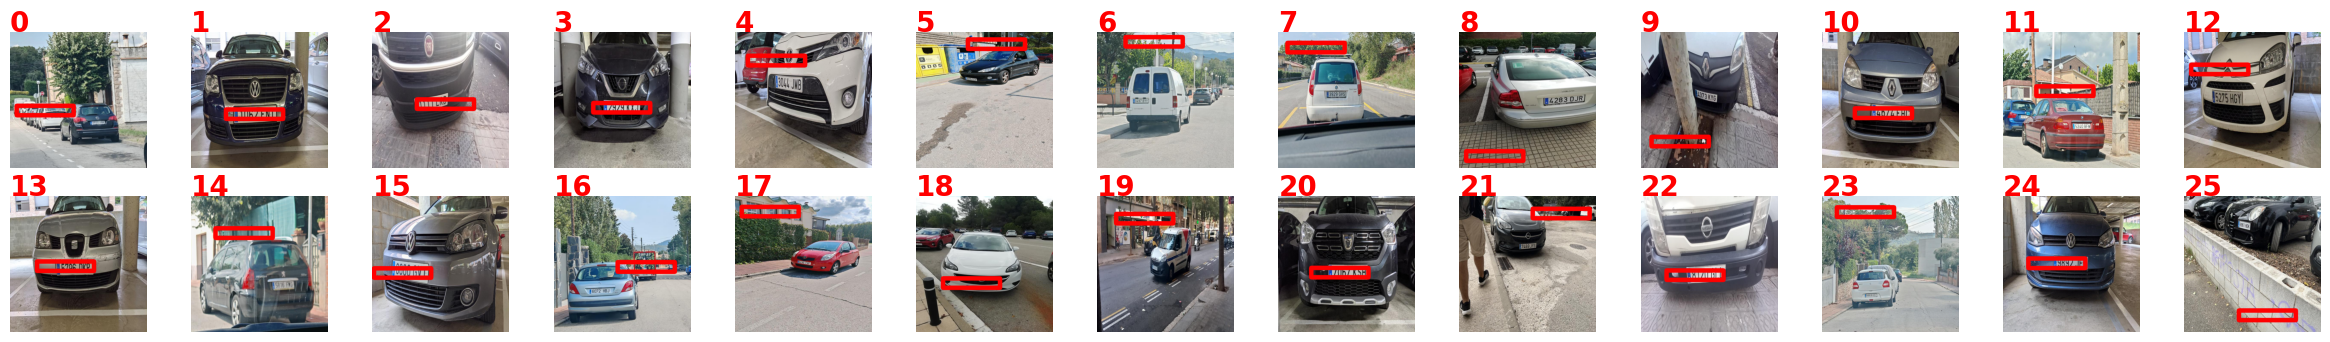

In [27]:
plot_images(results, rows=2, sep=0.3)

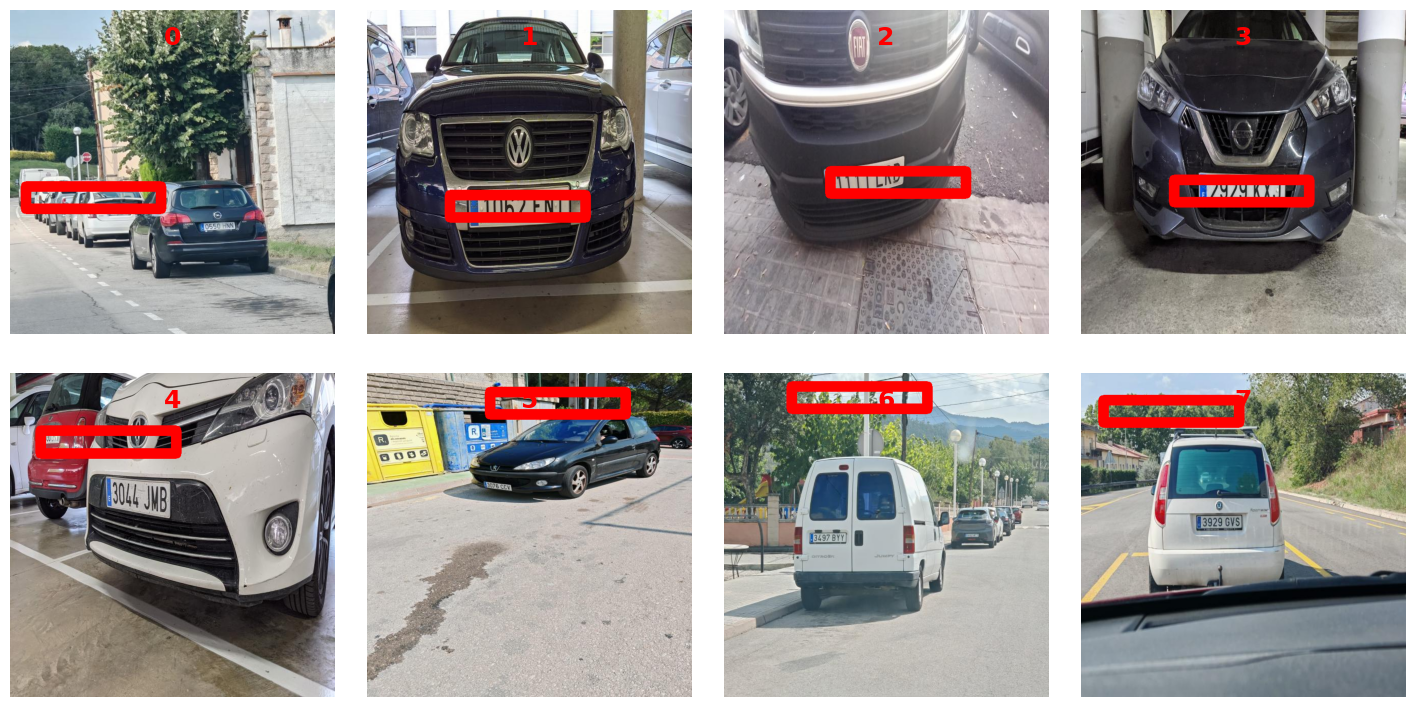

In [51]:
def plot_images(images, rows=2, n_images=None, sep=1.5, cmap='gray'):
    if n_images is None:
        n_images = len(images)
    
    n_images = min(n_images, len(images))
    
    
    cols = (n_images + rows - 1) // rows  
    
    # Ajustar el tamaño de la figura y el espaciado entre las imágenes
    fig, axs = plt.subplots(rows, cols, figsize=(cols * sep * 3, rows * sep * 3))
    axs = axs.flatten() 
    
    res_images = images[:n_images][::-1]  

    for i, ax in enumerate(axs):
        if i < n_images:
            ax.imshow(res_images.pop(), cmap=cmap)
            ax.axis('off')
            
            ax.text(0.5, 0.95, str(i), color='red', fontsize=18, fontweight='bold', 
                    ha='center', va='top', transform=ax.transAxes)
        else:
            ax.axis('off')
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


plot_images(results, rows=2, n_images=8)


In [14]:
print(len(result_boxes))

26


In [24]:
print(list(zip(result_boxes,ground_truths))[0])
print(result_boxes[1])
print(ground_truths['1062FNT_jpg.rf.e25368be438c8a1674da49f87b0195a6.jpg'])

((31, 349, 297, 393), '0550HNN_jpg.rf.79fa3912c92496ee635323f4eb29276c.jpg')
(163, 366, 430, 410)
[(0, 0.46796875, 0.6078125, 0.3234375, 0.14921875)]


In [35]:
path = "C:/Users/Usuario/Documents/GitHub/ANPR-GIA/Datasets/test/images/"
images = [path+img for img in os.listdir(path) if img.endswith(".jpg") or img.endswith(".jpeg")]
math_morph_predictions = {}

for img,box in zip(images,result_boxes):
    name = img.split('/')[-1]
    left_original,top_original,right_original,bottom_original = box
    width = right_original - left_original
    height = bottom_original - top_original

    x_center = (left_original + right_original) / 2
    y_center = (top_original + bottom_original) / 2

    
    img_cv = cv2.imread(img)
    img_width,img_height = img_cv.shape[0], img_cv.shape[1] 
    

    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    width_norm = width / img_width
    height_norm = height / img_height

    yolo_coordinate = (0,x_center_norm, y_center_norm, width_norm, height_norm)

    math_morph_predictions [name]= [yolo_coordinate] 
    

In [36]:
print(len(math_morph_predictions))
print(math_morph_predictions)
print(ground_truths)

26
{'0550HNN_jpg.rf.79fa3912c92496ee635323f4eb29276c.jpg': [(0, 0.25625, 0.5796875, 0.415625, 0.06875)], '1062FNT_jpg.rf.e25368be438c8a1674da49f87b0195a6.jpg': [(0, 0.46328125, 0.60625, 0.4171875, 0.06875)], '1111LRB_jpg.rf.9408c5a550f980ad9d44e3845a0bdcf4.jpg': [(0, 0.53515625, 0.5328125, 0.4171875, 0.06875)], '2929KXJ_jpg.rf.7b51d3ae84d4ced20ac39627603ec69b.jpg': [(0, 0.49375, 0.559375, 0.415625, 0.06875)], '3044JMB_jpg.rf.85bdd93a73b83e9318c53def8cb78d05.jpg': [(0, 0.30234375, 0.21484375, 0.4171875, 0.0703125)], '3076CCV_jpg.rf.f26e06a31a48a47cd53ff9715f12c5e2.jpg': [(0, 0.58671875, 0.0953125, 0.4171875, 0.06875)], '3497BYY_jpg.rf.1a84b6203bf8cfc847b4ad41dade93cc.jpg': [(0, 0.41640625, 0.078125, 0.4171875, 0.06875)], '3929GVS_jpg.rf.67f0fe121d406321d9dc9d1d6e1c131f.jpg': [(0, 0.27734375, 0.1203125, 0.4171875, 0.06875)], '4283DJR_jpg.rf.4bd8f0d4ee2b6d6ccb04230c69184a03.jpg': [(0, 0.26015625, 0.91171875, 0.4171875, 0.0703125)], '4373KYG_jpg.rf.7ad25abb634e9460a372bb0abfc08833.jpg': [(

In [52]:
# Supongamos que ya tienes los resultados de YOLO en 'results_yolo' y los ground truth anotados en 'ground_truths'
metrics = evaluate_predictions(math_morph_predictions,ground_truths, iou_threshold=0.1)

print("MathMorph vs Ground Truth:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")

MathMorph vs Ground Truth:
total_ground_truth: 26
total_predictions: 26
true_positives: 10
false_positives: 16
false_negatives: 16
precision: 0.38461538461538464
recall: 0.38461538461538464
false_positive_images: ['0550HNN_jpg.rf.79fa3912c92496ee635323f4eb29276c.jpg', '3044JMB_jpg.rf.85bdd93a73b83e9318c53def8cb78d05.jpg', '3076CCV_jpg.rf.f26e06a31a48a47cd53ff9715f12c5e2.jpg', '3497BYY_jpg.rf.1a84b6203bf8cfc847b4ad41dade93cc.jpg', '3929GVS_jpg.rf.67f0fe121d406321d9dc9d1d6e1c131f.jpg', '4283DJR_jpg.rf.4bd8f0d4ee2b6d6ccb04230c69184a03.jpg', '4373KYG_jpg.rf.7ad25abb634e9460a372bb0abfc08833.jpg', '5240BFM_jpg.rf.86cb57af3ad06da0aaa887e9393f611f.jpg', '5275HGY_jpg.rf.35bd8f4b9ea7bb337a83c2bc003eea9b.jpg', '5816FWG_jpg.rf.0de76c5cbd777a6a9400d4e9db58313a.jpg', '6072HBJ_jpg.rf.6c9a765de1dd7f4beb1bdaa4802b5707.jpg', '6230FXF_jpg.rf.97bd7b202aea559e70840f4c5f396407.jpg', '7007KFD_jpg.rf.b0104d0aeb03bef0f1d3f15cdc0407b8.jpg', '7469JYS_jpeg.rf.0f0550def6bf7de6c2e521f45cb06be5.jpg', '9869KST_jpg.rf